<a href="https://colab.research.google.com/github/garciasergio94y/TFM/blob/LSTM_onehot_samples/LSTM_onehot_samples_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalación y carga de librerías:

packages <- c("readr", "readxl", "purrr", "dplyr", "filesstrings",
              "stringr", "tidyr", "lubridate", "ggplot2",
              "tictoc", "wavelets", "reticulate", "abind",
              "tensorflow", "tfdatasets", "keras")

# Función para instalar paquetes si no están ya instalados
install_packages <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    }
}

# Aplicar la función para cada uno de los paquetes
lapply(packages, install_packages)

require(readr)
require(readxl)
require(purrr)
require(dplyr)
require(filesstrings)
require(stringr)
require(tidyr)
require(lubridate)
require(ggplot2)
#require(caret)
require(wavelets)
require(tictoc)
require(reticulate)
require(abind)
require(tensorflow)
require(tfdatasets)
require(keras)


Loading required package: readr

Loading required package: readxl

Loading required package: purrr

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: filesstrings

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘filesstrings’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘strex’


Loading required package: stringr

Loading required package: tidyr

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: ggplot2

Loading required package: tictoc

Warning message in library(package, lib

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

Loading required package: filesstrings


Attaching package: ‘filesstrings’


The following object is masked from ‘package:dplyr’:

    all_equal


Loading required package: wavelets

Loading required package: tictoc

Loading required package: reticulate

Loading required package: abind

Loading required package: tensorflow

Loading required package: tfdatasets

Loading required package: keras



In [2]:
workingdir <- getwd()
datadir <- file.path(workingdir, "Datos/daily_s")
eventdir <- file.path(workingdir, "Datos/daily_s/Event")
eventdir_old <- file.path(workingdir, "Datos/daily_s/Event/old")
lotdir <- file.path(workingdir, "Datos/daily_s/Lot")
lotdir_old <- file.path(workingdir, "Datos/daily_s/Lot/old")
qcdir <- file.path(workingdir, "Datos/daily_s/qc")
qcdir_old <- file.path(workingdir, "Datos/daily_s/qc/old")
resultsdir <- file.path(workingdir, "Resultados")
figuresdir <- file.path(workingdir, "Resultados/Figuras")

In [ ]:
tensorflow::tf_gpu_configured()

TensorFlow built with CUDA:  TRUE 
GPU device name:  /device:GPU:0

[1] TRUE

Lectura de archivos de datos

In [5]:
# Leer archivo dataset desde Github:
url <- "https://raw.githubusercontent.com/garciasergio94y/TFM/LSTM_onehot_samples/Resultados/data_sel_tr?token=GHSAT0AAAAAACDFXH5LBAIBLHCLYSTELJJOZDSEDBQ"
data_sel_tr <- read.csv(url)

# Guardar una copia local:
write.csv(data_sel_tr, file = "data_sel_tr", row.names = F, col.names = F) 


Warning message in write.csv(data_sel_tr, file = "data_sel_tr", row.names = F, col.names = F):
“attempt to set 'col.names' ignored”


In [7]:
# Convertir fechas en formato POSIXct:
data_sel_tr[,1] %<>% as.POSIXct(tz = "Europe/Madrid")
head(data_sel_tr)

,TIEMPO_MUESTRA,RESULTADO,W1,W2,W3,W4,W5,W6,W7,W8,⋯,V5,V6,V7,V8,V9,PACIENTE_SEXO,EDAD_BIN,ANALIZADOR,CODIGO_PRUEBA,CTRL
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,2022-07-01 23:43:01,0.128,0.1330702,-0.48218981,0.4076077,-0.085139907,2.296534e-01,5.265680e-01,-1.301906,1.159744,⋯,3.164701e-01,-2.276030,1.524866,2.401652,-99999,M,Adulto,DXI800 num 1,CLC00638,0
2,2022-07-01 23:34:01,0.045,0.0398048,-0.12198745,0.3524334,-0.054897129,2.381541e-01,5.217751e-01,-1.355061,1.106987,⋯,3.555069e-01,-2.270413,1.516775,2.386019,-99999,F,Anciano,DXI800 num 1,CLC00638,0
3,2022-07-01 02:16:09,2.400,2.3343280,0.40777892,6.3948257,0.170757979,-9.999900e+04,-9.999900e+04,-99999.000000,-99999.000000,⋯,-9.999900e+04,-99999.000000,-99999.000000,-99999.000000,-99999,M,Anciano,DXI800 num 2,CLC00544,0
4,2022-07-01 23:43:01,0.128,0.3011685,0.08686758,0.2372284,0.003601688,2.412237e-01,5.199918e-01,-1.406706,1.053865,⋯,3.967966e-01,-2.256904,1.508809,2.370393,-99999,M,Adulto,DXI800 num 1,CLC00638,0
5,2022-07-01 23:34:01,0.045,-0.4250092,0.02542740,0.1287398,0.088017741,2.374190e-01,5.214336e-01,-1.456832,1.000413,⋯,4.401376e-01,-2.235242,1.500968,2.354775,-99999,F,Anciano,DXI800 num 1,CLC00638,0
6,2022-07-01 02:16:09,2.400,3.3719282,0.12079282,4.3254634,-0.097094162,-9.999900e+04,-9.999900e+04,-99999.000000,-99999.000000,⋯,-9.999900e+04,-99999.000000,-99999.000000,-99999.000000,-99999,M,Anciano,DXI800 num 2,CLC00544,0


# Definición de funciones para transformación de variables, normalización y secuenciación de series de datos:


## Función ```normalize_train```.

Para la normalización de las variables continuas del dataset de entrenamiento y sustitución de valores NA en los coeficientes wavelet por un valor numérico arbitrario fácilmente enmascarable. Devuelve también una lista de vectores de medias y de desviaciones estándar que luego se usan como argumentos en para las funciones de normalización de los datasets de validación y test. De esta forma, el escalado y normalización se realiza con la misma media y desviación del set de entrenamiento para los otros dos datasets.

In [8]:
normalize_train <- function(data) {
   
  # Identificar las columnas que empiezan por W y la columna 'RESULTADO'
  wavelet_cols <- grep("^[WV]", colnames(data), value = TRUE)
  result_col <- "RESULTADO"
  
  # Calcular medias y desviaciones estándar por grupos de pruebas y   analizador:
  means <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
    summarise(across(c(result_col, wavelet_cols),
                     ~mean(., na.rm = T))) 
  
  std_devs <- data %>% 
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>% 
    summarise(across(c(result_col, wavelet_cols),
                     ~sd(., na.rm = T)))
  
  # Normalizar las columnas de resultado y coeficientes wavelet
  norm_data <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
    mutate(across(c(result_col, wavelet_cols), scale))%>%
    mutate(across(wavelet_cols,
                           ~ifelse(is.na(.), -99999, .))) %>%
    ungroup()
  
  # Devolver el dataframe escalado y las medias y desviaciones estándar:
  
  return(list(scaled_data = as.data.frame(norm_data), 
              means = means, stdev = std_devs))
}

## Función ```norm_test_val```.

Análoga a ```normalize_train```, pero con la diferencia de que usa la media y desviación estándar del dataset de entrenamiento para validar los datasets de validación y test:

In [9]:
norm_test_val <- function(data, means, stds) {
  
  # Identificar las columnas numéricas y seleccionarlas
  wavelet_cols <- grep("^[WV]", colnames(data), value = TRUE)
  result_col <- c("RESULTADO")
  test_cols <- "CODIGO_PRUEBA"
  cols <- c(result_col, wavelet_cols, test_cols)
  
  # Seleccionar medias y desviaciones de resultados y coeficientes   wavelet:
  means_r <- train_n$means
  stds_r <- train_n$stdev
  means_wl <- train_n$means[wavelet_cols]
  stds_wl <- train_n$stdev[wavelet_cols]
  
  # Normalizar por cada prueba las columnas de resultado y coeficientes wavelet usando las medias y desviaciones estándar de train suministradas:
  means <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
    left_join(means_r, by = c("ANALIZADOR", "CODIGO_PRUEBA"), 
              suffix = c(".val", ".means")) %>%
     ungroup()
   
  stds <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
     left_join(stds_r, by = c("ANALIZADOR", "CODIGO_PRUEBA"),
               suffix = c(".val", ".sd")) %>%
    ungroup()
     
    
  norm_data <- data %>%
    mutate(., RESULTADO.st =
             (.[,result_col]-
                select(means,
                       starts_with(result_col) &
                       ends_with(".means"))) /
                select(stds,
                       starts_with(result_col) &
                       ends_with(".sd"))
           ) %>%
    mutate(WAVELETS.st =
             across(all_of(wavelet_cols),
                    ~ (. - select(means, 
                                  starts_with(cur_column()) &
                                    ends_with(".means"))[[1]]) /
                      select(stds,
                             starts_with(cur_column()) &
                               ends_with(".sd"))[[1]])
           ) %>%
    select(-c(result_col, wavelet_cols)) %>%
    unnest(c(WAVELETS.st, RESULTADO.st)) %>%
    relocate(starts_with("RESULTADO"), .after = 1) %>%
    relocate(starts_with("W"), .after = 2) %>%
    relocate(starts_with("V"), .before = PACIENTE_SEXO) 
    
  names(norm_data)[2]<-result_col
  
  return(as.data.frame(norm_data))
}

## Función ```code_cat_var```.

Convierte las variables categóricas tipo string en vectores numéricos y realiza una codificción one-hot, creando una lista que retiene en un vector la información de los niveles de los factores. 

In [10]:
code_cat_var <- function(data) {
  # Eliminación de la columna CODIGO_PRUEBA si solo tiene una          categoría:
  if(length(unique(data$CODIGO_PRUEBA))==1){
    data %<>% select(., -CODIGO_PRUEBA)
    }
  
  # Eliminación de los casos con sexo indeterminado, debido a que son   muy minoritarios y crean una variable innecesaria:
  
  data %<>% filter(PACIENTE_SEXO != "U")
  
  # Detección de strings:
  cat_vars <- which(sapply(data, is.character))
  # Conversión a factores:
  data_cat <- lapply(data[,cat_vars], as.factor)
  # Extracción de niveles:
  levels <- lapply(data_cat, levels)
  
  # Codificar one-hot todas las variables factor:
  encoded_cols <- lapply(seq_along(data_cat), function(i) {
    cols <- model.matrix(~ factor(data_cat[[i]]) - 1)
    colnames(cols) <- paste0(names(data)[cat_vars[i]], "_",
                             levels[[i]])
    cols
    })
  
  # Unir columnas codificadas con conjunto de datos original:
  if (!"CODIGO_PRUEBA" %in% names(data)) {
    data_encoded <- bind_cols(data %>% 
                                select(-all_of(cat_vars)),
                                encoded_cols)
    } else {
      data_encoded <-  bind_cols(data %>%
                                   select(c(-all_of(cat_vars),
                                            "CODIGO_PRUEBA")),
                                 encoded_cols)
      }
  
    # Reordenar columnas:
  data_encoded <- data_encoded %>%
  relocate(CTRL, .after = everything())
  
  return(list(data = data_encoded, levels = levels))
}


## Función ```unique_lab_cases```.

Crea un índice de casos únicos de combinaciones de variables categóricas.

In [11]:
  unique_lab_cases <- function(df, categorical_vars) {
  unique_groups <- unique(df[categorical_vars])
  
  code <- apply(unique_groups, 1, function(row) {
    paste0(ifelse(row == 1, 1, 0), collapse = "")
  })
  unique_groups %<>% mutate(., code)
  coded_df <- df %>%
    merge(unique_groups, ., by = colnames(unique_groups)
          [-length(colnames(unique_groups))])
  coded_df <- coded_df[, c(colnames(df), "code")]
  
  return(coded_df)
}

## Función ```create_lstm_data.1```.

Diseñada para la creación de lotes de series temporales de longitud k (lookback). Basada en la función presentada en Chollet François, Deep learning with Python. Shelter Island, NY: Manning Publications Co; 2018. 335 p. Cap. 6.3.2 

In [12]:
create_lstm_data.1 <- 
  function(data, lookback, delay, min_index, max_index,
           shuffle = FALSE, batch_size, step = 1,
           predseries) {
    
  if (is.null(max_index)) max_index <- nrow(data) - delay -1
  i <- min_index + lookback
  gen <- function() {
    if (shuffle) {
      rows <- sample(c((min_index+lookback):max_index), 
                     size = batch_size)
    } else {
      if (i + batch_size >= max_index)
        i <<- min_index + lookback
      rows <- c(i:min(i+batch_size, max_index))
      i <<- i + length(rows)
    }
    samples <- array(0, dim = c(length(rows),
                                lookback / step,
                                dim(data)[[-1]]))
    targets <- array(0, dim = c(length(rows)))
    for (j in 1:length(rows)) {
      indices <- seq(rows[[j]] - lookback, rows[[j]],
                     length.out = dim(samples)[[2]])
      samples[j,,] <- data[indices, ]
      targets[[j]] <- data[rows[[j]] + delay, predseries]
    }
    list(samples, targets)
  }
  return(gen)
}

## Funciones ```train_gen``` y ```val_gen```.

Funciones generadoras globales de series para train y validation, Estas funciones generan de manera indefinida series con los datos de entrenamiento y validación, usando de manera consecutiva las funciones generadoras individuales almacenadas junto a los subconjuntos de datos con las posibles combinaciones de variables categóricas. Si se llega a la generación última se repite el proceso desde la primera. Incluyen un TryCatch para evitar la parada del modelo si se encuentran secuencias de datos vacías.  

In [30]:
train_gen <- function() {
  indices <- sample(length(train_k))
  
  for (i in indices) {
    sequence <- tryCatch(
      train_k[[i]](),
      error = function(e) {
        warning("Empty sequence error occurred in the generator. Trying the next one.")
        return(NULL)
      }
    )
    
    if (!is.null(sequence)) {
      return(sequence)
    }
  }
  
  NULL
}


val_gen <- function() {
  indices <- sample(length(val_k))
  
  for (i in indices) {
    sequence <- tryCatch(
      val_k[[i]](),
      error = function(e) {
        warning("Empty sequence error occurred in the generator. Trying the next one.")
        return(NULL)
      }
    )
    
    if (!is.null(sequence)) {
      return(sequence)
    }
  }
  
  NULL
}

# División de datasets:
Se divide el dataset en 50% de datos para entrenamiento, 25% para test y 25% para validación. Para evitar fraccionar las unidades temporales diarias usamos percentiles de la secuencia temporal en días: 

In [14]:

time_point_50 <- as.POSIXct(as.Date(
  quantile(data_sel_tr[,1], 0.5)))

time_point_75 <- as.POSIXct(as.Date(
  quantile(data_sel_tr[,1], 0.75)))

time_point_50
time_point_75

# Muestra de entrenamiento:
train <- data_sel_tr %>%
  subset(.[,1] <= time_point_50) 

# Muestra de validación:
val <- data_sel_tr %>%
  subset(data_sel_tr[,1] > time_point_75)
  

# Muestra de test:
#test <- data_sel_code$data %>%
# subset(.[,1] > time_point_50 &
  #         .[,1] <= time_point_75)

             50% 
"2022-11-08 UTC" 

             75% 
"2022-12-23 UTC" 

## Normalización de los datasets.

In [15]:
# Set de entrenamiento:
train_n <- normalize_train(train)

# Set de validación:
val_n <- norm_test_val(val, means = train_n$means,
                              stds = train_n$stdev)

Warning message:
“There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `across(c(result_col, wavelet_cols), ~mean(., na.rm = T))`.
Caused by warning:
! Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(result_col)

  # Now:
  data %>% select(all_of(result_col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
`summarise()` has grouped output by 'ANALIZADOR'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'ANALIZADOR'. You can override using the
`.groups` argument.


## Codificación de variables mediante one-hot.

In [16]:
train_code <- code_cat_var(train_n$scaled_data)

val_code <- code_cat_var(val_n)

## Redistribución temporal de casos y oversampling.

## Preparación de series temporales de longitud k agrupadas por categorías y por fechas en los datasets de training y validación. 

In [17]:
# Creación de los códigos identificativos únicos de combinaciones de variables categóricas para el set de training usando la función unique_lab_cases e indicando las posiciones de las variables categóricas en train_code$data que se deseen incluir (en este caso el analizador): 

train_indx <- unique_lab_cases(train_code$data,
                               categorical_vars = c(28:29))

# Extraemos los códigos para realizar un diccionario de traducción de códigos únicos a índices numéricos:
code_values <- unique(train_indx[,"code"])
code_dictionary <- data.frame(code = code_values)
code_dictionary %<>%  
  mutate(., index = as.numeric(factor(code_values, 
                                      levels = code_values)))

# Sustituimos los códigos de train_indx por sus índices numéricos:
train_indx$index <- code_dictionary$index[match(train_indx$code, code_dictionary$code)]
train_indx$code <- NULL

# Creamos todas las posibles combinaciones de códigos y fechas:

train_indx$TIEMPO_MUESTRA %<>% as.Date()

combinations_train <- expand.grid(code = code_values,
                            date = unique(train_indx$TIEMPO_MUESTRA))

# Traducimos los códigos a índices:

combinations_train$index <-
  code_dictionary$index[match(combinations_train$code,
                              code_dictionary$code)]

# Creación de lista de funciones generadoras de las series temporales de longitud k por categoría de CODIGO_PRUEBA del dataset de entrenamiento. Se generan series para cada día de observación conteniendo los resultados pertenecientes a cada una de las categorías elegidas:

# Hiperparámetros para generar las series temporales:
lookback <- 10 # Longitud de la secuencia previa al target.
delay <- 0 # Se escoge 0 debido a que los targets futuros ya se                 colocaron en la misma fila que la muestra del día                  anterior.
batch_size <- 30 # Tamaño de batch.
min_index <- 1 # Indice de partida de la serie temporal.
predseries <- length(train_indx) - 2 # Posición en el dataset de la variable a predecir (CTRL) una vez eliminados TIEMPO_MUESTRA e index.

train_k <- mapply(function(index, date) {
  data <- as.matrix(
  train_indx[train_indx[,"TIEMPO_MUESTRA"] == date &
               train_indx[,"index"] == index,
             - c(1, length(train_indx))])
  max_index <- nrow(data)-delay
  
  create_lstm_data.1(
    data = data,
    lookback = lookback,
    delay = delay,
    batch_size = batch_size,
    min_index = min_index,
    max_index = max_index,
    predseries = predseries)
},
index = combinations_train$index,
date = combinations_train$date,
SIMPLIFY = T
) 


# Cálculo del número de steps de training:
train_steps <- round((nrow(train_code$data) - lookback) / batch_size)

In [18]:
# Creación de los índices identificativos de combinaciones de variables categóricas para el set de validación:
val_indx <- unique_lab_cases(val_code$data, 
                             categorical_vars = c(28:29))

# Usamos el diccionario de códigos creado anteriormente: 
val_indx$index <- code_dictionary$index[match(val_indx$code,
                                            code_dictionary$code)]
val_indx$code <- NULL

# Generar todas las combinaciones de index y date para el set de validación:

val_indx$TIEMPO_MUESTRA %<>% as.Date()

combinations_val <- expand.grid(code = code_values,
                            date = unique(val_indx$TIEMPO_MUESTRA))

# Traducimos los códigos a índices:

combinations_val$index <-
  code_dictionary$index[match(combinations_val$code,
                              code_dictionary$code)]

# Creación de lista de funciones generadoras del dataset de validación:

val_k <- mapply(function(index, date) {
  data <- as.matrix(
  val_indx[val_indx[,"TIEMPO_MUESTRA"] == date &
               val_indx[,"index"] == index,
             - c(1, length(val_indx))])
  max_index <- nrow(data)-delay
  
  create_lstm_data.1(
    data = data,
    lookback = lookback,
    delay = delay,
    batch_size = batch_size,
    min_index = min_index,
    max_index = max_index,
    predseries = predseries)
  },
  index = combinations_val$index,
  date = combinations_val$date,
  SIMPLIFY = T
)  

# Cálculo del número de steps de validación:
val_steps <- round((nrow(val_code$data)-lookback) / batch_size)

# Definición del modelo de Machine Learning. Red Neuronal Recurrente LSTM (Long-short term memory).

## Diseño del modelo

In [21]:
set.seed(123)

input_shape <- c(lookback, dim(train_code$data[,-1])[[-1]])

model_1 <- keras_model_sequential() %>%
  
  layer_masking(mask_value = -99999, input_shape = input_shape) %>%
  layer_lstm(units = 32, dropout = 0.1, recurrent_dropout = 0.5,
             input_shape = c(NULL, lookback,
                             dim(train_code$data[,-1])[[-1]])) %>%
  layer_dense(units = 1, activation = "sigmoid")

summary(model_1)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 masking_1 (Masking)                (None, 10, 57)                  0           
 lstm_1 (LSTM)                      (None, 32)                      11520       
 dense_1 (Dense)                    (None, 1)                       33          
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
________________________________________________________________________________


## Métrica F1

In [ ]:
# Función para calcular F1 como métrica para el modelo:
  f1_score <- function(y_true, y_pred) {
  true_positives <- sum(backend()$round(backend()$clip(y_true * y_pred, 0, 1)))
  possible_positives <- sum(backend()$round(backend()$clip(y_true, 0, 1)))
  predicted_positives <- sum(backend()$round(backend()$clip(y_pred, 0, 1)))
  precision <- true_positives / (predicted_positives + backend()$epsilon())
  recall <- true_positives / (possible_positives + backend()$epsilon())
  f1_score <- 2 * precision * recall / (precision + recall + backend()$epsilon())
  return(f1_score)
}

## Compilación y callbacks

In [22]:
model_1 %<>% compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = list("binary_accuracy",
                 f1_score)
  )

callbacks <- list(
  callback_model_checkpoint(file.path(resultsdir, "lstm_1.keras",
                                     save_best_only = TRUE)))

## Entrenamiento

In [31]:
history_1 <- model_1 %>% fit_generator(
  generator = train_gen,
  steps_per_epoch = train_steps,
  epochs = 10,
  validation_data = val_gen,
  validation_steps = val_steps,
  callbacks = callbacks
)

Warning message in fit_generator(., generator = train_gen, steps_per_epoch = train_steps, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”


ERROR: ignored

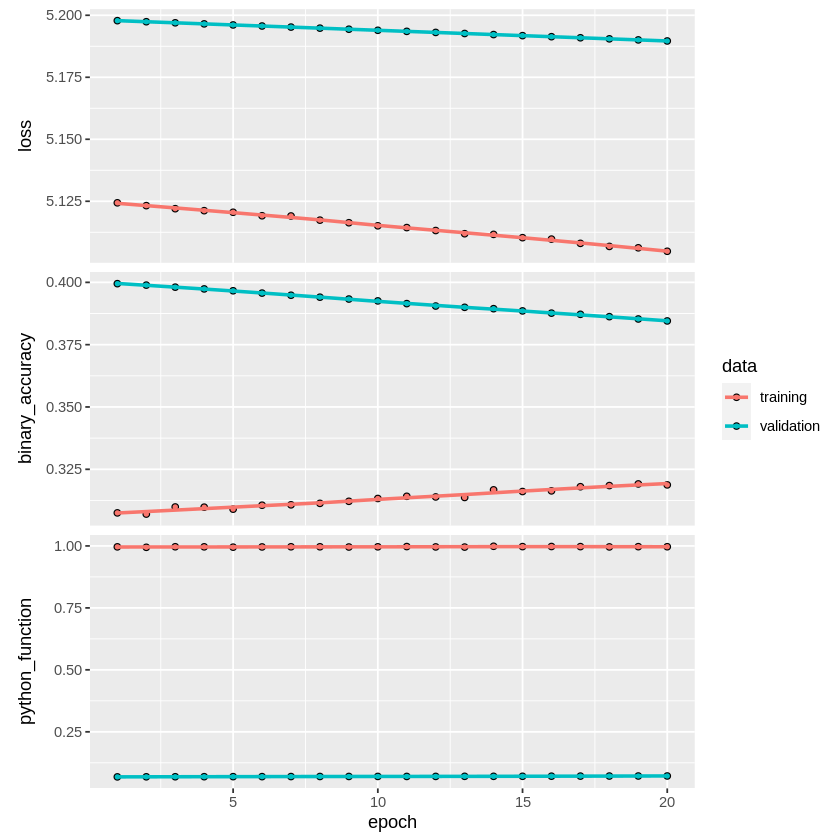

In [ ]:
plot(history_1)

## Evaluación del modelo

In [ ]:
path <- file.path(resultsdir, "lstm_1.keras")
model <- load_model_tf(path) 
sprintf("Test MAE: %.2f", evaluate(model, test_ds)["mae"]) 

## Cálculo de la línea base de sentido común:
Calcula la exactitud mínima del modelo, basada en la predicción de todos los casos con el target más frecuente

In [ ]:
evaluate_naive_method <- function(data_df, ctrl_colname) { 
  # Cálculo de la moda de CTRL:
  ctrl_mode <- as.numeric(names(sort(table(
    data_df[[ctrl_colname]]),
    decreasing = TRUE)[1]))

  # Cálculo de accuracy:
  actual_ctrl <- data_df[[ctrl_colname]]
  predicted_ctrl <- rep(ctrl_mode, length(actual_ctrl))
  accuracy <- sum(actual_ctrl == predicted_ctrl) /
    length(actual_ctrl)

  accuracy
}

# Cálculo de accuracy basado en predecir con la moda:
accuracy_train <- evaluate_naive_method(train_n$scaled_data, "CTRL")
accuracy_val <- evaluate_naive_method(val_n, "CTRL")

sprintf("Training naive accuracy: %.2f", accuracy_train)
sprintf("Validation naive accuracy: %.2f", accuracy_val)